# Generate figures based on the data from Stylus scores

In [1]:
import os
import re
import sys
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from itertools import permutations
from PIL import Image, ImageDraw
from random import randint, seed

from xmlparse import xmlToGeometry, loadRef, loadGeometry, loadGeometryFNames
from score_strokes import alignStrokes

import numpy as np

In [2]:
han_char = "5EA6"
ref_g, ref_l, output_size = loadRef(han_char, "Reference")
g, l = loadGeometry("HanBitmap", han_char, output_size, f_read = ["54"])[0]
print(len(ref_g), len(g))

9 9


In [3]:
alignments = np.array(alignStrokes(g, ref_g, l, ref_l), dtype=int)

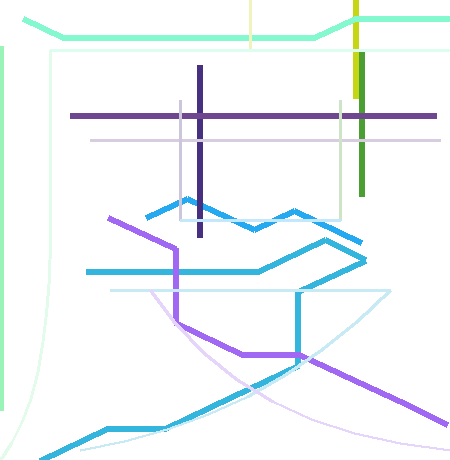

In [4]:
img = Image.new(mode="RGBA", size=output_size)
seed(ref_l[0][0])
colors = [(randint(0, 256), randint(0, 256), randint(0, 256)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]

for i, r in enumerate(alignments):
    draw = ImageDraw.Draw(img)
    for a in range(len(g[i])-1):
        x1, y1 = g[i][a]
        x2, y2 = g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[r])

for i, c in enumerate(colors_t[:-1]):
    draw = ImageDraw.Draw(img)
    for a in range(len(ref_g[i])-1):
        x1, y1 = ref_g[i][a]
        x2, y2 = ref_g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=3, fill=c)
display(img)

In [5]:
perms = np.array([i for i in permutations(range(1, 10))]) # generate permutation map so we can reference which stroke alignment corrisponds to the max exhaustive scores

# 400_exhaust.npy in model mapping
exhaustive_scores = np.load("Exhaustive/exhaust_5EA6_5EA6_Genes_testing set_maint_0.2 on 5EA6.01_5EA6.01.38.gene.npy")
max_exhaustive = np.max(exhaustive_scores)
max_exhaustive_perm = perms[np.argmax(exhaustive_scores)]

alignment_ind = np.argmax(np.array([(perms[i] == alignments+1).all() for i in range(len(perms))]))

alignment_ind == np.argmax(exhaustive_scores) # check if the score for alignment is the same as the one for exhastive max

True

In [6]:
def sortExhaustiveScores(ref_char, han_char, f_read, exhaust_dir = "Exhaustive"):
    exhaust_alignment_scores = np.zeros((len(f_read), 2))
    identical_alignments = np.zeros(len(f_read), dtype = bool)
    ref_g, ref_l, output_size = loadRef(ref_char, "Reference")
    geometries, files = loadGeometryFNames("HanBitmap", han_char, output_size, f_read = f_read)
    for i in range(len(geometries)):
        (g, l), f = geometries[i], files[i].replace("/", "_")
        alignments = np.array(alignStrokes(g, ref_g, l, ref_l), dtype=int)+1
        print(alignments)
        exhaustive_scores = np.load(f"{exhaust_dir}/exhaust_{ref_char}_{han_char}_{f}.npy")
        max_exhaustive = np.max(exhaustive_scores)
        alignment_ind = np.argmax(np.array([(perms[i] == alignments).all() for i in range(len(perms))]))
        exhaust_alignment_scores[i] = (max_exhaustive, exhaustive_scores[alignment_ind])
        identical_alignments[i] = np.argmax(exhaustive_scores) == alignment_ind
    return exhaust_alignment_scores, identical_alignments

In [7]:
ref_char = "5EA6"
han_char = "5EA6"
f_read = ["54"]
exhaust_vs_heuristic, identical_counts = sortExhaustiveScores(ref_char, han_char, f_read)
# exhaust_5EA6_5EA6_Genes_testing set_maint_0.2 on 5EA6.01_5EA6.01.38.gene.npy

[6 7 5 4 1 2 3 8 9]


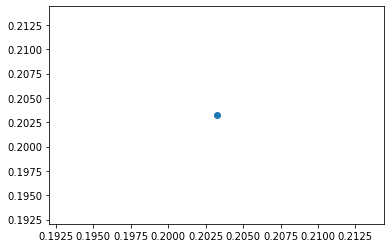

In [8]:
x, y = exhaust_vs_heuristic[:, 0], exhaust_vs_heuristic[:, 1]
plt.scatter(x, y)